In [11]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

In [12]:
raw_data_path = list(Path("../stimuli/obvious_gaussian_clusters").iterdir())[0]

In [13]:
raw_data = np.load(raw_data_path)

## Structure of data

* x
* y
* cluster_number

In [170]:
print("Shape: {}".format(raw_data.shape))
raw_data[:10]

Shape: (20, 3)


array([[346.93670781, 773.11255145,   0.        ],
       [359.13029152, 819.82879763,   0.        ],
       [336.35303862, 703.03756795,   0.        ],
       [382.0850861 , 672.65241735,   0.        ],
       [389.62233413, 744.58613532,   0.        ],
       [432.12742467,  82.18252923,   1.        ],
       [482.90067379,  31.5120241 ,   1.        ],
       [462.49873341,  25.6787751 ,   1.        ],
       [495.89468675,  83.64957469,   1.        ],
       [476.9516279 ,  62.23464235,   1.        ]])

In [171]:
raw_points = raw_data[:, :2]

In [396]:
# parameters
number_of_neurons_in_network = 100
bottomk_number = 10
learning_rate = 0.1
training_iterations = 100

In [801]:
class Network:
    
    def __init__(self, D):
        # D are the values of the neurons
        self.D = D
        # W are the weights of the neurons
        self.W = np.ones(D.shape[0]) / 2
    
    @classmethod
    def generate_initial(cls, X):
        n_dims = X.shape[1]
        ranges = []
        for col_idx in range(n_dims):
            col_values = X[:, col_idx]
            min = np.min(col_values)
            max = np.max(col_values)
            ranges.append((min, max))

        final_transposed = []
        for min, max in ranges:
            final_transposed.append(np.random.uniform(min, max, number_of_neurons_in_network))

        return cls(np.array(final_transposed).T)
    
    def plot(self, X):
        fig, ax = plt.subplots()
        ax.scatter(X[:, 0], X[:, 1], color="red")
        ax.scatter(self.D[:, 0], self.D[:, 1], color="blue", alpha=self.W)
        return ax
    
    def __repr__(self):
        return f"<Network D={len(self.D)}>"
        
network = Network.generate_initial(raw_points)

In [802]:
# O(n)
def bottomk_indices(v, k):
    return np.argpartition(v, k)[:k]

def not_indices(indices, shape):
    new_indices = np.ones(shape, dtype=bool)
    new_indices[indices] = False
    return new_indices

<AxesSubplot:>

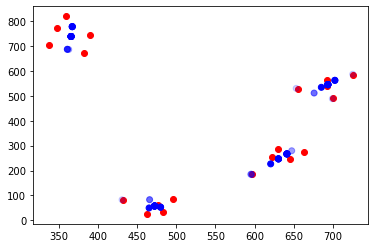

In [838]:
shape = raw_points.shape
for data_point in raw_points:
    difference_vectors =  network.D - data_point.reshape(1, shape[1])
    euclidean_distances = np.linalg.norm(difference_vectors, ord=2, axis=1)
    indices = bottomk_indices(euclidean_distances, bottomk_number)
    close_neurons_distances = euclidean_distances[indices]
    closest_value_index = np.argmax(close_neurons_distances)
    network.D[indices] = network.D[indices] - learning_rate * difference_vectors[indices]
    
    weight_change_reduction_indices = not_indices(indices, network.W.shape)
    network.W[weight_change_reduction_indices] = np.clip(network.W[weight_change_reduction_indices] - 0.001, 0, 1)
    network.W[indices] = np.clip(network.W[indices] + 0.010, 0, 1)

network.plot(raw_points)